<center>
    <font size="6"><b>Introduction to Time Series Prediction</b></font>
    <br>
    <font size="3">(draft version)</font>
</center>

<br>

<center>
    <font size="3"><b>Piotr Lipiński</b></font>
    <br>
    Computational Intelligence Research Group, Institute of Computer Science, University of Wroclaw, Poland
    <br>
    lipinski@cs.uni.wroc.pl
</center>

### Abstract:

This notebook presents an introduction to time series prediction and illustrates the problem on the Airline Passengers dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
import seaborn as sns
import warnings
from contextlib import contextmanager

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

%matplotlib inline

In [2]:
@contextmanager
def plotter(xlabel='', ylabel='', title='', **legend):
	plt.figure(figsize=(12,4))
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.title(title)
	plt.legend(**legend)
	try:
		yield 1
	finally:
		plt.show()

## Time Series Data

In [3]:
df = pd.read_csv('../data/airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df_test = df.iloc[int(0.35*len(df)):]
df = df.iloc[:int(0.35*len(df))]


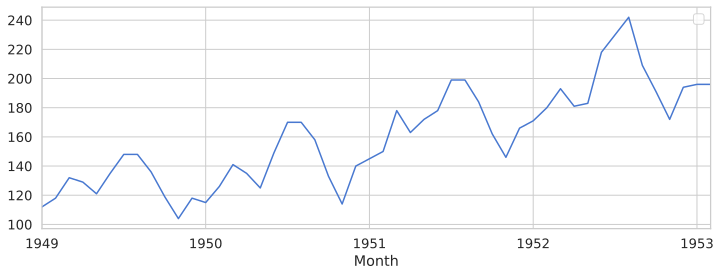

In [4]:
with plotter():
	df['Passengers'].plot()

In [5]:
df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df_test['trend'] = df_test['Passengers'].ewm(halflife=12).mean()

In [6]:
df['detrended_subtract'] = df['Passengers'] - df['trend']
df['detrended'] = df['Passengers'] / df['trend']
df_test['detrended_subtract'] = df_test['Passengers'] - df_test['trend']
df_test['detrended'] = df_test['Passengers'] / df_test['trend']

In [7]:
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)
df['preprocessed'] = df['detrended'] - df['seasonality']
df['preprocessed_divide'] = df['detrended'] / df['seasonality']
df['preprocessed_subtract'] = df['detrended_subtract'] - df['seasonality']

In [8]:
df_test_seasonality = df_test['detrended'].groupby(df_test.index.month).mean().rename('seasonality')
df_test = df_test.join(df_test_seasonality, how='left', on=df_test.index.month)
df_test['preprocessed'] = df_test['detrended'] - df_test['seasonality']
df_test['preprocessed_divide'] = df_test['detrended'] / df_test['seasonality']
df_test['preprocessed_subtract'] = df_test['detrended_subtract'] - df_test['seasonality']

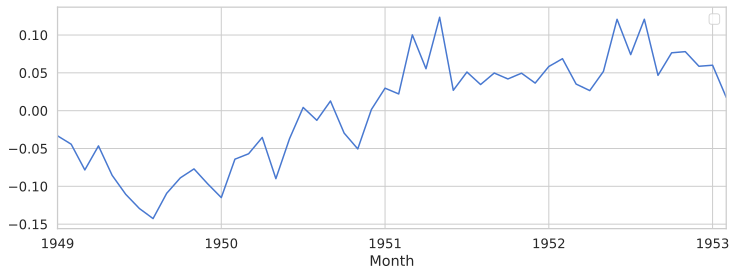

In [26]:
with plotter():
	df['preprocessed'].plot()

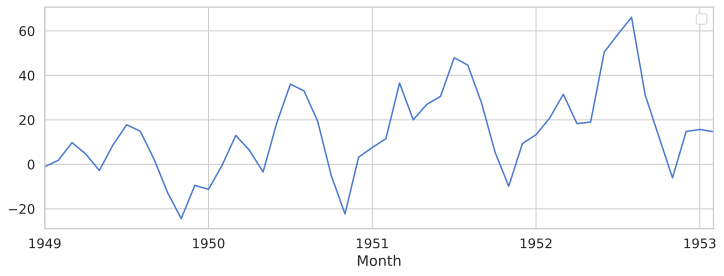

In [27]:
with plotter():
	df['preprocessed_subtract'].plot()

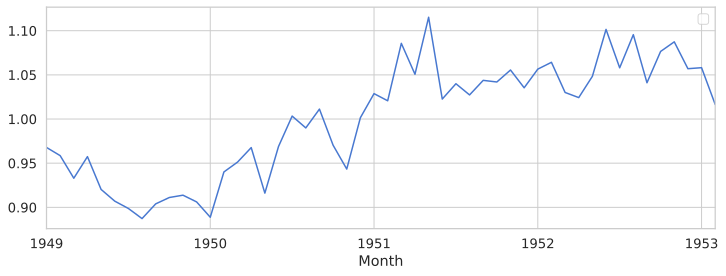

In [28]:
with plotter():
	df['preprocessed_divide'].plot()

## Prediction by the linear regression (preprocessed)

In [11]:
X_train = df['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y_train = df['preprocessed'].values[1:]
X_test = df_test['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y_test = df_test['preprocessed'].values[1:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_predicted = np.zeros(len(df_test))
y_predicted[1:] = reg.predict(X_test)

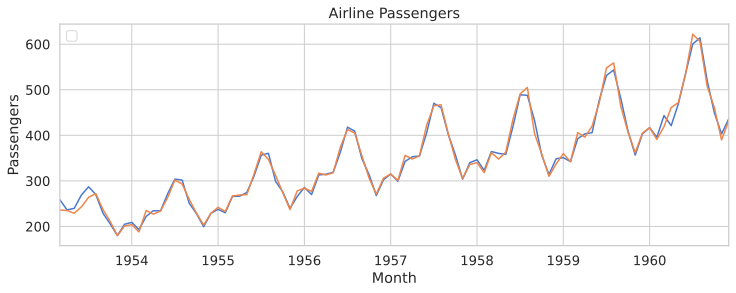

MSE: 111.7456
MAE: 7.6702
MAPE: 0.0224


In [12]:
df_test['prediction_raw'] = y_predicted
df_test['prediction'] = (df_test['prediction_raw'] + df_test['seasonality']) * df_test['trend']

with plotter(xlabel="Time", ylabel="Passengers", title="Airline Passengers", loc='upper left'):
	df_test['prediction'].plot(label='predicted data')
	df_test['Passengers'].plot(label='original data')

print('MSE: %0.4f' % ((df_test['Passengers'] - df_test['prediction'])**2).mean())
print('MAE: %0.4f' % (df_test['Passengers'] - df_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_test['Passengers'] - df_test['prediction']) / df_test['Passengers']).abs().mean())

## Prediction by the linear regression (raw)

In [13]:
X_train = df['Passengers'].shift(1).values[1:].reshape(-1, 1)
y_train = df['Passengers'].values[1:]
X_test = df_test['Passengers'].shift(1).values[1:].reshape(-1, 1)
y_test = df_test['Passengers'].values[1:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_predicted = np.zeros(len(df_test))
y_predicted[1:] = reg.predict(X_test)

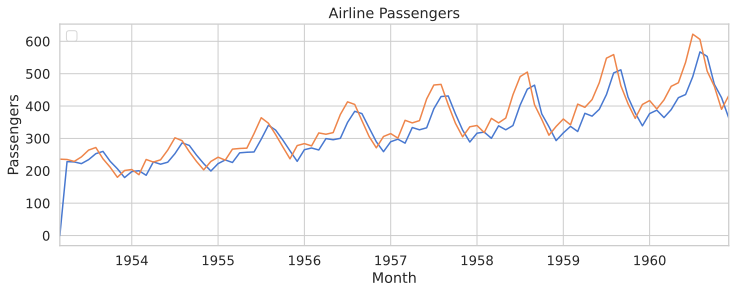

MSE: 2630.9736
MAE: 38.3538
MAPE: 0.1089


In [14]:
df_test['prediction'] = y_predicted

with plotter(xlabel="Time", ylabel="Passengers", title="Airline Passengers", loc='upper left'):
	df_test['prediction'].plot(label='predicted data')
	df_test['Passengers'].plot(label='original data')

print('MSE: %0.4f' % ((df_test['Passengers'] - df_test['prediction'])**2).mean())
print('MAE: %0.4f' % (df_test['Passengers'] - df_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_test['Passengers'] - df_test['prediction']) / df_test['Passengers']).abs().mean())

## Prediction by the linear regression (subtracted trend)

In [15]:
X_train = df['preprocessed_subtract'].shift(1).values[1:].reshape(-1, 1)
y_train = df['preprocessed_subtract'].values[1:]
X_test = df_test['preprocessed_subtract'].shift(1).values[1:].reshape(-1, 1)
y_test = df_test['preprocessed_subtract'].values[1:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_predicted = np.zeros(len(df_test))
y_predicted[1:] = reg.predict(X_test)

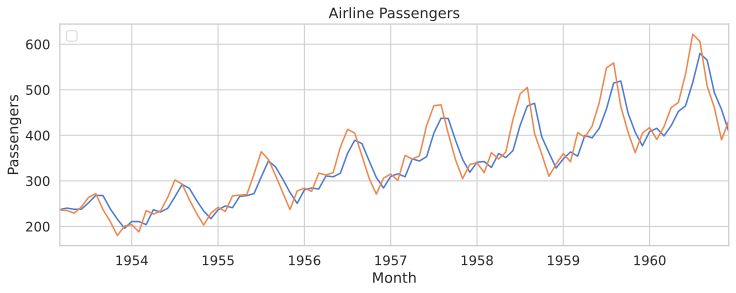

MSE: 1305.6247
MAE: 28.7527
MAPE: 0.0806


In [16]:
df_test['prediction_raw'] = y_predicted
df_test['prediction'] = (df_test['prediction_raw'] + df_test['seasonality']) + df_test['trend']

with plotter(xlabel="Time", ylabel="Passengers", title="Airline Passengers", loc='upper left'):
	df_test['prediction'].plot(label='predicted data')
	df_test['Passengers'].plot(label='original data')

print('MSE: %0.4f' % ((df_test['Passengers'] - df_test['prediction'])**2).mean())
print('MAE: %0.4f' % (df_test['Passengers'] - df_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_test['Passengers'] - df_test['prediction']) / df_test['Passengers']).abs().mean())

## Prediction by the linear regression (divided seasonality)

In [19]:
X_train = df['preprocessed_divide'].shift(1).values[1:].reshape(-1, 1)
y_train = df['preprocessed_divide'].values[1:]
X_test = df_test['preprocessed_divide'].shift(1).values[1:].reshape(-1, 1)
y_test = df_test['preprocessed_divide'].values[1:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_predicted = np.zeros(len(df_test))
y_predicted[1:] = reg.predict(X_test)

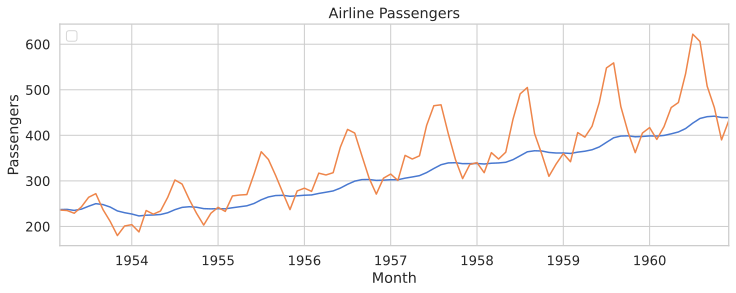

MSE: 3929.3668
MAE: 43.9368
MAPE: 0.1152


In [24]:
df_test['prediction_raw'] = y_predicted
df_test['prediction'] = (df_test['prediction_raw'] + df_test['seasonality']) + df_test['trend']

with plotter(xlabel="Time", ylabel="Passengers", title="Airline Passengers", loc='upper left'):
	df_test['prediction'].plot(label='predicted data')
	df_test['Passengers'].plot(label='original data')

print('MSE: %0.4f' % ((df_test['Passengers'] - df_test['prediction'])**2).mean())
print('MAE: %0.4f' % (df_test['Passengers'] - df_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_test['Passengers'] - df_test['prediction']) / df_test['Passengers']).abs().mean())

## Foobar

<Axes: xlabel='Month'>

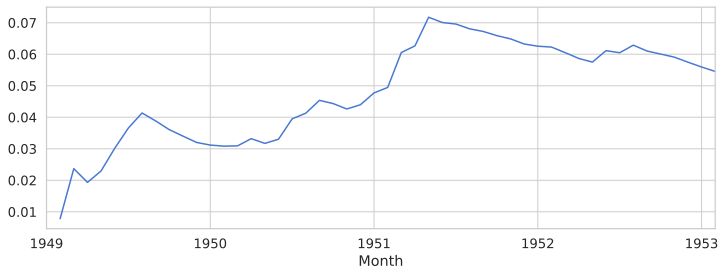

In [53]:
df['preprocessed'].ewm(halflife=12).std().plot()

<Axes: xlabel='Month'>

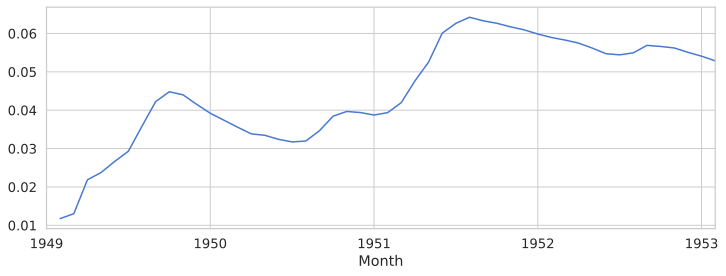

In [77]:
import numpy as np
# df['preprocessed_smooth'] = df['preprocessed']**2
df['preprocessed_smooth'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()
df_test['preprocessed_smooth'] = df_test['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()
# df_test['preprocessed_smooth'] = df_test['preprocessed']**2
df['preprocessed_smooth'].ewm(halflife=12).std().plot()

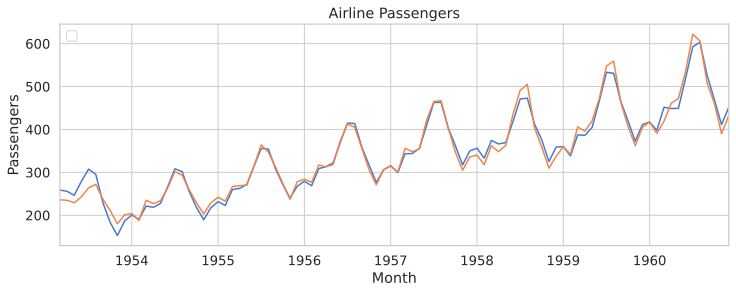

MSE: 208.7393
MAE: 11.3299
MAPE: 0.0356


In [78]:
X_train = df['preprocessed_smooth'].shift(1).values[1:].reshape(-1, 1)
y_train = df['preprocessed_smooth'].values[1:]
X_test = df_test['preprocessed_smooth'].shift(1).values[1:].reshape(-1, 1)
y_test = df_test['preprocessed_smooth'].values[1:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_predicted = np.zeros(len(df_test))
y_predicted[1:] = reg.predict(X_test)

df_test['prediction_raw'] = y_predicted
df_test['prediction'] = (df_test['prediction_raw'] + df_test['seasonality']) * df_test['trend']

with plotter(xlabel="Time", ylabel="Passengers", title="Airline Passengers", loc='upper left'):
	df_test['prediction'].plot(label='predicted data')
	df_test['Passengers'].plot(label='original data')

print('MSE: %0.4f' % ((df_test['Passengers'] - df_test['prediction'])**2).mean())
print('MAE: %0.4f' % (df_test['Passengers'] - df_test['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_test['Passengers'] - df_test['prediction']) / df_test['Passengers']).abs().mean())